In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

In [2]:
# https://www.footballoutsiders.com/stats/nfl/snap-counts
snap_counts = pd.read_csv('snap_counts.csv')
snap_counts['jersey'] = snap_counts.name.apply(lambda x: x.split('-')[0])
snap_counts['name'] = snap_counts.name.apply(lambda x: x.split('-')[1])

snap_counts = snap_counts.loc[snap_counts.season<2019] # we don't have 2019 pff grades in the dataset

In [3]:
# https://github.com/ajreinhard/NFL - thank you!!!
pff_grade = pd.read_csv('ajreinhard_pff/PFF_Grades_ALL_Reg.csv')
pff_ids = pd.read_csv('ajreinhard_pff/PFF_id.csv')
pff_grades = pff_ids.merge(pff_grade, left_on=['year','player_id'], right_on=['year','id']).drop(columns=['id', 'season'])

def team_name_change(name):
    if name=='BLT':
        return 'BAL'
    elif name=='ARZ':
        return 'ARI'
    elif name=='CLV':
        return 'CLE'
    elif name=='HST':
        return 'HOU'
    elif name=='SD':
        return 'LAC'
    elif name=='SL':
        return 'LAR'
    elif name=='LA':
        return 'LAR'
    return name

def pos_to_pos_group(pos):
    if pos in ['T', 'C', 'G']:
        return 'OL'
    if pos in ['DI', 'ED']:
        return 'DL'
    if pos in ['LS', 'P', 'K']:
        return 'ST'
    if pos in ['CB', 'S']:
        return 'DB'
    if pos=='HB':
        return 'RB'
    return pos
    

def player_name(player):    
    if player=='Julio Jones':
        return 'Ju.Jones'
    split = player.split()
    if len(split)>2:
        if split[2] in ['Jr.', 'Sr.', 'III', 'II', 'IV', 'V']:
            pass
        else:
            return f'{player[0]}.{" ".join(split[1:])}'
    return f'{player[0]}.{split[1]}'

pff_grades['team_name'] = pff_grades.team_name.apply(team_name_change)
pff_grades.drop_duplicates(subset=['year', 'player_id'], inplace=True)
pff_grades['name'] = pff_grades['player'].apply(player_name)
pff_grades['position_group'] = pff_grades['position'].apply(pos_to_pos_group)

pff_grades = pff_grades[pff_grades.year>2011]

In [4]:
# a lot of the grades are NaN. Let's break it down by position.
print("% missing grades:")
print(f'total: {int(100*len(pff_grades.loc[(pff_grades.grade.isnull())])/len(pff_grades))}%')
for pos_group in pff_grades['position_group'].unique():
    num = len(pff_grades.loc[(pff_grades.grade.isnull()) & (pff_grades.position_group==pos_group)])
    den = len(pff_grades.loc[(pff_grades.position_group==pos_group)])
    if den!=0:
        print(f'{pos_group}: {int(100*num/den)}%')

% missing grades:
total: 15%
QB: 3%
TE: 10%
WR: 6%
ST: 99%
OL: 69%
RB: 2%
LB: 3%
DL: 0%
DB: 0%
FB: 35%


In [5]:
merge = pff_grades.merge(
    snap_counts.rename(columns={'position':'position_group'}),
    how='outer',
    left_on=['year', 'team_name', 'position_group','name'],
    right_on=['season', 'team', 'position_group', 'name'],
    indicator=True).drop(columns=['player_id', 'player_game_count'])
merge._merge.value_counts() 
# left_only: # of player-seasons that were in pff_grades but not snap_counts
# right_only: # of player-seasons that were in snap_counts but not in pff_grades

both          11327
right_only     3857
left_only      1417
Name: _merge, dtype: int64

In [6]:
missing_pff = merge.loc[(merge._merge=='right_only')]
missing_pff
# seems like missing values mainly fall under the following categories:
# a) name in snap count dataset is not simply "F.Lastname" - may have extra letters in first name
# b) position group discrepancy - 'LB' in snap count data, 'ED' in PFF, etc. Damn you, 3-4 vs 4-3 position naming conventions!
# c) players who played 0 snaps.

,player,position,team_name,year,page,grade,name,position_group,season,team,tot_snaps,off_snaps,off_snap_pct,def_snaps,def_snap_pct,st_snaps,st_snap_pct,jersey,_merge
12744,NaN,NaN,NaN,NaN,NaN,NaN,Tel.Smith,LB,2018.0,JAX,1108.0,0.0,0.00%,1020.0,99.50%,88.0,20.60%,50,right_only
12745,NaN,NaN,NaN,NaN,NaN,NaN,D.Ford,LB,2018.0,KC,1021.0,0.0,0.00%,1021.0,86.70%,0.0,0.00%,55,right_only
12746,NaN,NaN,NaN,NaN,NaN,NaN,SL.Griffin,DB,2018.0,SEA,1012.0,0.0,0.00%,941.0,95.00%,71.0,15.50%,26,right_only
12747,NaN,NaN,NaN,NaN,NaN,NaN,T.Watt,LB,2018.0,PIT,964.0,0.0,0.00%,903.0,86.40%,61.0,13.30%,90,right_only
12748,NaN,NaN,NaN,NaN,NaN,NaN,J.Smith,WR,2018.0,PIT,962.0,960.0,86.00%,0.0,0.00%,2.0,0.40%,19,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16596,NaN,NaN,NaN,NaN,NaN,NaN,M.Masifilo,DL,2012.0,TB,0.0,0.0,0.00%,0.0,0.00%,0.0,0.00%,97,right_only
16597,NaN,NaN,NaN,NaN,NaN,NaN,D.Baldridge,OL,2012.0,TEN,0.0,0.0,0.00%,0.0,0.00%,0.0,0.00%,76,right_only
16598,NaN,NaN,NaN,NaN,NaN,NaN,T.Compton,OL,2012.0,WAS,0.0,0.0,0.00%,0.0,0.00%,0.0,0.00%,68,right_only
16599,NaN,NaN,NaN,NaN,NaN,NaN,A.Gettis,OL,2012.0,WAS,0.0,0.0,0.00%,0.0,0.00%,0.0,0.00%,73,right_only


In [7]:
merge_a = merge.copy()

def snap_and_grade_fn(row):
    if row['page']=='offense':
        return (row['off_snaps'], row['grade'])
    elif row['page']=='defense':
        return (row['def_snaps'], row['grade'])
    return (0,0)

merge_a['snaps_and_grade'] = merge.apply(snap_and_grade_fn, axis=1)

In [8]:
pbp = pd.DataFrame()
for year in range(2012, 2019):
    i_df = pd.read_csv(f'pbp_data/play_by_play_{year}.csv.gz', compression='gzip', low_memory=False)
    pbp = pd.concat([pbp, i_df])

In [9]:
def snap_weighted_group_grade(snap_and_grade):
    num = sum(snaps*grade for snaps, grade in snap_and_grade)
    denom = sum(snaps for snaps,_ in snap_and_grade)
    if denom!=0:
        return num/denom
    return 0

group_grades = merge_a.groupby(['season','team','position_group'], as_index=False).agg({'snaps_and_grade':snap_weighted_group_grade}).rename(columns={'snaps_and_grade':'weighted_grade'})

group_grades.set_index(['season', 'team'], inplace=True)

group_grades['off_epa'] = pbp.groupby(['season', 'posteam']).agg({'epa':'mean'})
group_grades['def_epa'] = pbp.groupby(['season', 'defteam']).agg({'epa':'mean'})

group_grades.reset_index(inplace=True)

In [10]:
def year_to_year_corr(columns, groupby, data):
    cols = [groupby, 'season'] + columns 
    data = data[cols]
    ldata = data.groupby(by=groupby).shift(-1)
    data.columns = [groupby, 'prev_season'] + [f'prev_{col}' for col in columns]
    new_data = pd.concat((data, ldata), axis=1).dropna(subset=['season']).drop(columns=['prev_season','season'])
    tot_corr = new_data.corr(method='pearson')
    num_corr_cols = len(columns)
    corr = tot_corr.iloc[num_corr_cols:,num_corr_cols:]
    pred = tot_corr.iloc[0:num_corr_cols, num_corr_cols:]
    return corr,pred

correlations = pd.DataFrame(columns=['def_corr', 'off_corr'])
stabilities = pd.DataFrame(columns=['stability', 'pred_def', 'pred_off'])
for pos_group in group_grades.position_group.unique():
    data = group_grades.loc[group_grades.position_group==pos_group]
    c, p = year_to_year_corr(['weighted_grade', 'def_epa', 'off_epa'], 'team', data)
    correlations.loc[pos_group] = {'def_corr':c.loc['weighted_grade','def_epa'], 
                                   'off_corr':c.loc['weighted_grade','off_epa']}
    stabilities.loc[pos_group] = {'stability':p.loc['prev_weighted_grade', 'weighted_grade'], 
                                  'pred_def': p.loc['prev_weighted_grade', 'def_epa'],
                                  'pred_off': p.loc['prev_weighted_grade', 'off_epa']}
    
(correlations**2).sort_values('off_corr', ascending=False)
# OL probably ranks low since we're missing 70% of our data!

,def_corr,off_corr
QB,0.000090,0.635461
WR,0.019275,0.211811
TE,0.026908,0.204523
RB,0.003227,0.196009
OL,0.018716,0.119096
DB,0.436950,0.013989
FB,0.000017,0.011511
LB,0.076932,0.007173
DL,0.082800,0.000105
ST,NaN,NaN


In [11]:
(stabilities**2).sort_values('stability', ascending=False)

,stability,pred_def,pred_off
WR,0.924246,0.000001,0.011207
TE,0.884564,0.002588,0.089472
DL,0.830923,0.002534,0.002009
DB,0.801113,0.083761,0.000002
RB,0.785812,0.011901,0.013071
QB,0.695176,0.000860,0.156892
LB,0.383170,0.031217,0.003922
FB,0.341898,0.000154,0.006304
OL,NaN,0.009598,0.058742
ST,NaN,NaN,NaN


R^2: 0.6354613945675137


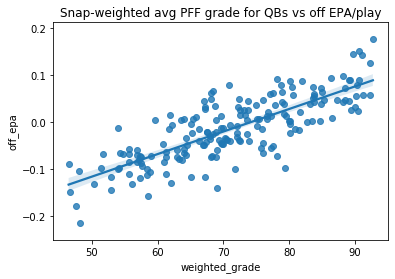

In [12]:
pos = 'QB'
side = 'off'
print(f"R^2: {(correlations**2).loc[pos, f'{side}_corr']}")
ax = sns.regplot(x='weighted_grade', y=f'{side}_epa', data=group_grades.loc[group_grades.position_group==pos])
t = ax.set_title(f'Snap-weighted avg PFF grade for {pos}s vs {side} EPA/play')

In [13]:
group_grades.loc[group_grades.position_group=='DL'].sort_values('weighted_grade', ascending=False)[:10][['season', 'team', 'position_group', 'weighted_grade']]

,season,team,position_group,weighted_grade
1927,2018.0,CHI,DL,89.153628
2120,2018.0,PHI,DL,80.711182
1819,2017.0,PIT,DL,79.779409
1985,2018.0,GB,DL,79.640813
1702,2017.0,JAX,DL,78.545387
2043,2018.0,LAR,DL,78.296066
2081,2018.0,NO,DL,77.467015
1810,2017.0,PHI,DL,77.269303
1995,2018.0,HOU,DL,77.196914
1158,2015.0,NYJ,DL,76.990635


In [25]:
data = pbp.groupby(['season','posteam']).agg({'epa':'mean', 'wp':'mean'}).rename(columns={'epa':'off_epa'})
data['def_epa'] = pbp.groupby(['season','defteam']).agg({'epa':'mean'})
group_grades.set_index(['season', 'team'], inplace=True)
for pos_group in group_grades.position_group.unique():
    data[f'{pos_group}_grade'] = group_grades.loc[group_grades.position_group==pos_group][['weighted_grade']]
group_grades.reset_index(inplace=True)
data.reset_index(inplace=True)
corrs = ((data.corr().drop(columns=['season']).iloc[1:])**2).sort_values('off_epa',ascending=False).round(3)
corrs.loc[[f'{pos}_grade' for pos in group_grades.position_group.unique()], 'wp'].sort_values(ascending=False)

QB_grade    0.414
DB_grade    0.273
WR_grade    0.191
RB_grade    0.072
OL_grade    0.070
TE_grade    0.068
LB_grade    0.040
DL_grade    0.030
FB_grade    0.000
ST_grade      NaN
Name: wp, dtype: float64

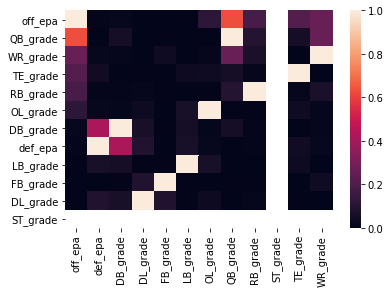

In [15]:
sns.heatmap(corrs)